In [39]:
import sys
import os

sys.path.insert(0, ('/').join(os.getcwd().split('/')[:-1]))
from py_wave_propagator import free_space_prop
from py_wave_propagator import volume_prop

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# Propagation to a non-parallel/oblique/angled plane

0. Confirm steps
1. Ground truth on oblique plane
2. Show results

/tmp/ipykernel_63018/4247406955.py:38: RuntimeWarning: divide by zero encountered in log10
  surf = ax.plot_surface(U_hat, V_hat, np.clip(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(gaussian_field)))), -2, 4), cmap=cm.coolwarm,


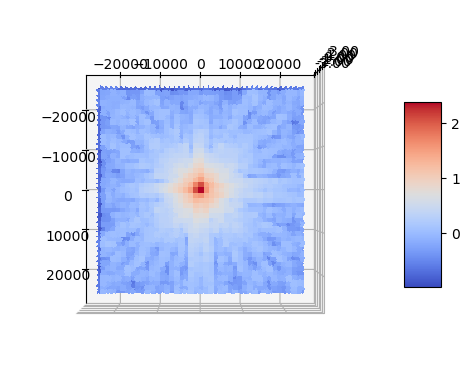

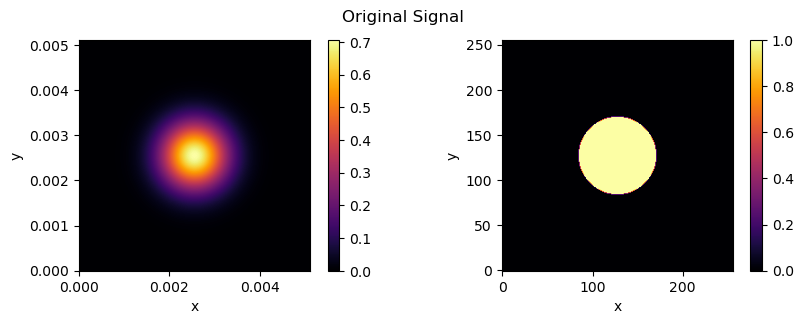

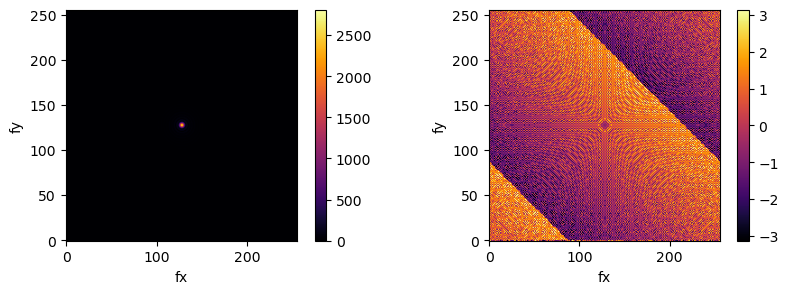

In [2]:
# generating a gaussian beam

def gaussian_beam(x, y, wavelength, waist_size, z, phase=0):
    k = 2 * np.pi / wavelength
    zR = np.pi * waist_size**2 / wavelength
    w_z = waist_size * np.sqrt(1 + (z / zR)**2)
    R_z = z * (1 + (zR / z)**2)
    gouy_phase = np.arctan(z / zR)
    
    w_0 = waist_size / np.sqrt(2)
    # phase_term = np.exp(1j * (k * z - k * x**2 / (2 * R_z) - gouy_phase + phase))
    thresh = x**2 + y**2 < waist_size
    phase_term = np.exp(1j * 1 * thresh)

    
    return (w_0 / w_z) * np.exp(-((x**2 + y**2) / w_z**2)) * phase_term

# Parameters
wl = 650*1e-6  # wavelength (in mm)
numPx = [256, 256]
sizePx = [0.02, 0.02]
waist_size = 0.75  # waist size of the beam (in mm)
z = 10  # propagation distance (in mm)

# Grid
x = np.linspace(-1*sizePx[0]*numPx[0]/2, sizePx[0]*numPx[0]/2, numPx[0])
y = np.linspace(-1*sizePx[1]*numPx[1]/2, sizePx[1]*numPx[1]/2, numPx[1])
X, Y = np.meshgrid(x, y)

# Generate Gaussian beam
gaussian_field = gaussian_beam(X, Y, wl, waist_size, z)

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

u_hat = v_hat = np.fft.fftshift(np.fft.fftfreq(256, 0.02e-3))
U_hat, V_hat = np.meshgrid(u_hat, v_hat, indexing='ij')
surf = ax.plot_surface(U_hat, V_hat, np.clip(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(gaussian_field)))), -2, 4), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-3, 3)

# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=90, azim=0, roll=0)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

cb = axs[0].imshow((np.abs(gaussian_field)), 
           extent=(0, 256*20e-6, 0, 256*20e-6), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[0])
# axs[0].set_title('Amplitude | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

cb = axs[1].imshow((np.angle(gaussian_field)), 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[1])
# axs[1].set_title('Phase | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.suptitle('Original Signal')

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

cb = axs[0].imshow(np.abs(np.fft.fftshift(np.fft.fft2(gaussian_field))), 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[0])
# axs[0].set_title('Amplitude | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[0].set_xlabel('fx')
axs[0].set_ylabel('fy')

cb = axs[1].imshow(np.angle(np.fft.fftshift(np.fft.fft2(gaussian_field))), 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[1])
# axs[1].set_title('Phase | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[1].set_xlabel('fx')
axs[1].set_ylabel('fy')

plt.show()


# Estimating GT at rotated plane

Translate by +/- 2.2170 mm


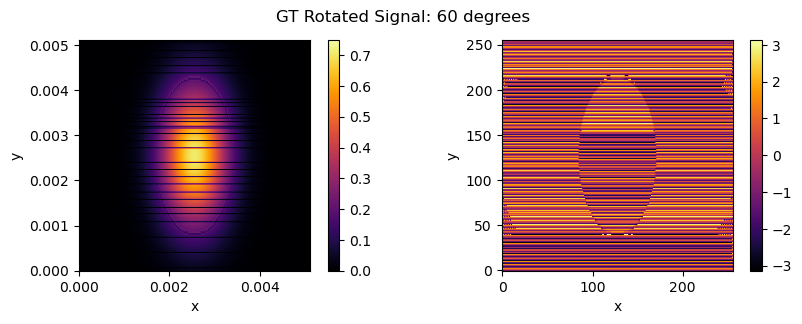

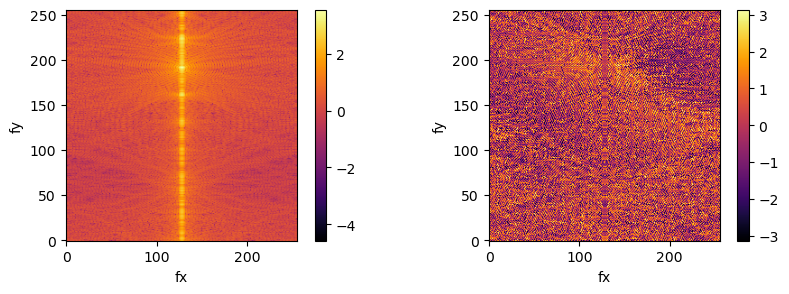

In [14]:
## GT simulation
rot_x = 60 # degrees
max_d = (0.02e-3*256/2)*np.sin(rot_x*np.pi/180)

del_d = max_d/128
del_x = del_d/np.sin(rot_x*np.pi/180)
del_y = del_d/np.tan(rot_x*np.pi/180)

print(f'Translate by +/- {max_d/1e-3:.4f} mm')

steps = 256
wl = 650*1e-9

wave_obj = free_space_prop.Wave2d(
    numPx = [256, 256], 
    sizePx = [0.02e-3, 0.02e-3], 
    wl = wl
)

wave_obj.wavefield(gaussian_field)
gt_rot_wave = np.zeros_like(gaussian_field)

wave_z_obl = []
for i, dist2 in enumerate(np.linspace(-max_d, max_d, steps)):
    wave_z_temp = wave_obj.propogate(dist2)
    gt_rot_wave[int(128*(0.02e-3*256/2 - (i+1)*del_x)/(0.02e-3*256/2)) + 128, :] = wave_z_temp[int(128*(np.cos(rot_x*np.pi/180)*0.02e-3*256/2 - (i+1)*del_y)/(0.02e-3*256/2)) + 128, :]

# gt_rot_wave = gaussian_filter(gt_rot_wave, 1, truncate=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
cb = axs[0].imshow((np.abs(gt_rot_wave)), 
                   vmax=0.75, vmin=0, 
                extent=(0, 256*20e-6, 0, 256*20e-6), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[0])
# axs[0].set_title('Amplitude | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
# axs[0].grid()

cb = axs[1].imshow((np.angle(gt_rot_wave)), 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[1])
# axs[1].set_title('Phase | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.suptitle(f'GT Rotated Signal: {rot_x} degrees')

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
cb = axs[0].imshow(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(gt_rot_wave)))), 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[0])
# axs[0].set_title('Amplitude | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[0].set_xlabel('fx')
axs[0].set_ylabel('fy')

cb = axs[1].imshow(np.angle(np.fft.fftshift(np.fft.fft2(gt_rot_wave))), 
        #    extent=(-5, 5, -5, 5), 
           cmap='inferno', origin='lower')
fig.colorbar(cb, ax=axs[1])
# axs[1].set_title('Phase | Paraxial Gaussian Beam at z = {:.1f} mm'.format(z))
axs[1].set_xlabel('fx')
axs[1].set_ylabel('fy')

plt.show()

## 1. Transformation to non-parallel plane

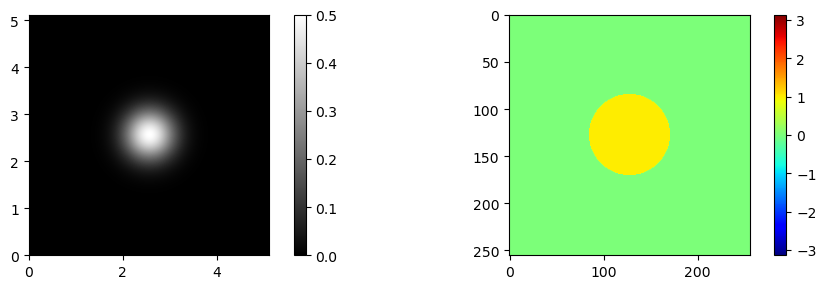

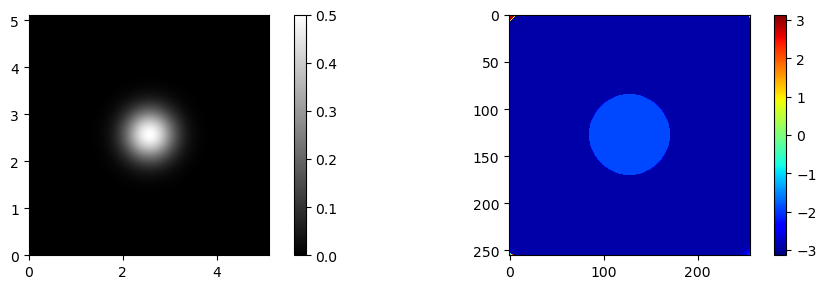

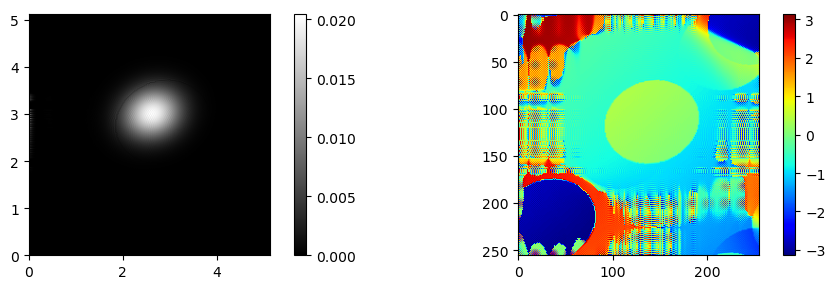

In [38]:
wave_obj = free_space_prop.Wave2d(
    numPx = [numPx[0], numPx[1]], 
    sizePx = [sizePx[0]*1e-3, sizePx[1]*1e-3], 
    wl = wl*1e-3
)

wave_obj.wavefield(gaussian_field)

fig, axs = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
cp_amp = axs[0].imshow(np.abs(wave_obj.wavefield_z0)**2, vmax=0.5, vmin=0., cmap='gray', extent=(0, 256*0.02, 0, 256*0.02))
cp_ang = axs[1].imshow((np.angle(wave_obj.wavefield_z0)), vmin=-1*np.pi, vmax=np.pi, cmap='jet')

plt.colorbar(cp_amp, ax=axs[0])
plt.colorbar(cp_ang, ax=axs[1])

plt.show()

_ = wave_obj.propogate(1e-3)

fig, axs = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
cp_amp = axs[0].imshow(np.abs(wave_obj.wavefield_z1)**2, vmax=.5, vmin=0., cmap='gray', extent=(0, 256*0.02, 0, 256*0.02))
cp_ang = axs[1].imshow(np.angle(wave_obj.wavefield_z1), vmin=-1*np.pi, vmax=np.pi, cmap='jet')

plt.colorbar(cp_amp, ax=axs[0])
plt.colorbar(cp_ang, ax=axs[1])
# axs[0].grid()
plt.show()

wavefield_obj = wave_obj.obliquePlaneProp(rotation=[30, 10], degrees=True, samples_ref_spectrum=1024, shift=False)

fig, axs = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
cp_amp = axs[0].imshow(np.abs(wavefield_obj)**2, vmin=0., cmap='gray', extent=(0, 256*0.02, 0, 256*0.02))
cp_ang = axs[1].imshow(np.angle(wavefield_obj), vmin=-1*np.pi, vmax=np.pi, cmap='jet')

plt.colorbar(cp_amp, ax=axs[0])
plt.colorbar(cp_ang, ax=axs[1])
# axs[0].grid()
plt.show()

(2048, 2048)


/tmp/ipykernel_63018/1965451366.py:45: RuntimeWarning: divide by zero encountered in log10
  surf = ax.plot_surface(U_hat, V_hat, np.clip(np.log10(np.abs(wave_z_freq_interp_fft)), -6, 4), cmap=cm.coolwarm,


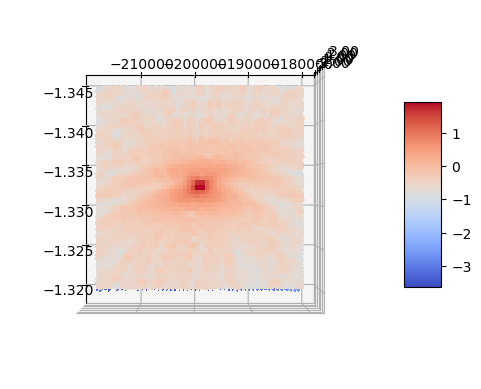

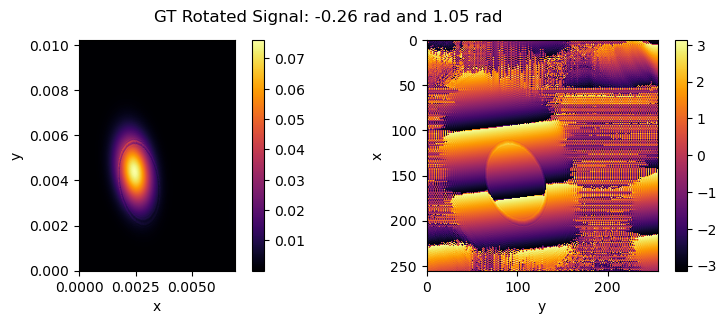

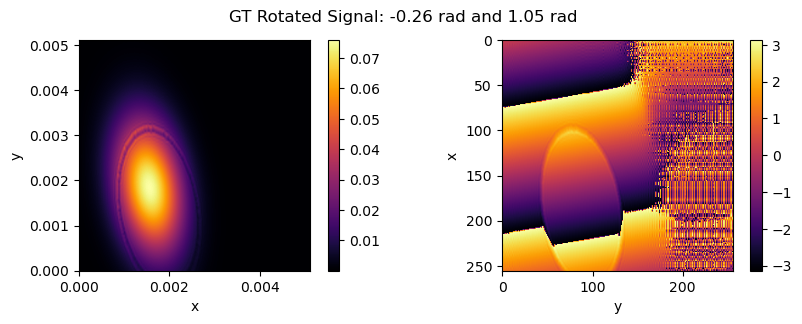

In [25]:
wl = 650*1e-9
rot_x = -15*np.pi/180 # degrees
rot_y = 60*np.pi/180 # degrees

u_hat = v_hat = np.fft.fftshift(np.fft.fftfreq(256, 0.02e-3))
U_hat, V_hat = np.meshgrid(u_hat, v_hat, indexing='ij')

wave_z_freq = np.fft.fftshift(np.fft.fft2(gaussian_field))

interp = RegularGridInterpolator((u_hat, v_hat), wave_z_freq, method='linear', bounds_error=False, fill_value=0.)

T_inv_x = np.array([[1, 0, 0], 
                    [0, np.cos(rot_x), -1*np.sin(rot_x)], 
                    [0, np.sin(rot_x), np.cos(rot_x)]], dtype=np.float64)

T_inv_y = np.array([[np.cos(rot_y), 0, np.sin(rot_y)], 
                    [0, 1, 0], 
                    [-1*np.sin(rot_y), 0, np.cos(rot_y)]], dtype=np.float64)

T_inv = np.matmul(T_inv_y, T_inv_x)

u_max = v_max = 1/(2*20e-6)
w_max = np.sqrt(1/(wl**2) - u_max**2 - v_max**2)

UVW_max = np.matmul(np.matmul(T_inv_x.transpose(), T_inv_y.transpose()), np.array([u_max, v_max, w_max]).reshape(3, 1))
UVW_min = np.matmul(np.matmul(T_inv_x.transpose(), T_inv_y.transpose()), np.array([-1*u_max, -1*v_max, w_max]).reshape(3, 1))
UVW_shift = -1*np.matmul(np.matmul(T_inv_x.transpose(), T_inv_y.transpose()), np.array([0, 0, 1/wl]).reshape(3, 1))

u_hat = np.linspace(UVW_min[0] - 0e3, UVW_max[0] + 0e3, 2048)
v_hat = np.linspace(UVW_min[1] - 0e3, UVW_max[1] + 0e3, 2048)

U_hat, V_hat = np.meshgrid(u_hat, v_hat, indexing='ij')
W_hat = np.sqrt(1/((wl)**2) - U_hat**2 - V_hat**2)

UVW = np.matmul(T_inv, np.stack([U_hat, V_hat, W_hat], axis=0).reshape(3, -1)).reshape(3, *U_hat.shape)
U, V, W = UVW

J = np.abs((T_inv[0, 1]*T_inv[1, 2] - T_inv[0, 2]*T_inv[2, 1])*U_hat/W_hat + (T_inv[0, 2]*T_inv[1, 0] - T_inv[0, 0]*T_inv[1, 2])*V_hat/W_hat + T_inv[0, 0]*T_inv[1, 1] - T_inv[0, 1]*T_inv[1, 0])
    
wave_z_freq_interp_fft = interp((U, V))
print(wave_z_freq_interp_fft.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(U_hat, V_hat, np.clip(np.log10(np.abs(wave_z_freq_interp_fft)), -6, 4), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-3, 3)

# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=90, azim=0, roll=0)
plt.show()

wave_z_freq_interp = np.fft.ifft2(np.fft.ifftshift(wave_z_freq_interp_fft*J))[:256, :256]

padx = int((256 - 256*np.cos(rot_y))/2)
pady = int((256 - 256*np.cos(rot_x))/2)
wave_z_freq_interp = np.pad(wave_z_freq_interp, 0)
# ((padx, padx), (pady, pady))
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
cb = axs[0].imshow((np.abs(wave_z_freq_interp)), 
                #    vmax=0.75, vmin=0,
                extent=(0, 256/(UVW_max[1] - UVW_min[1] + 0e3)[0], 0, 256/(UVW_max[0] - UVW_min[0] + 0e3)[0]),
           cmap='inferno')
fig.colorbar(cb, ax=axs[0])
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


cb = axs[1].imshow((np.angle(wave_z_freq_interp)), 
           cmap='inferno')
fig.colorbar(cb, ax=axs[1])
axs[1].set_xlabel('y')
axs[1].set_ylabel('x')

plt.suptitle(f'GT Rotated Signal: {rot_x:.2f} rad and {rot_y:.2f} rad')

plt.show()

cx = 256/(UVW_max[0] - UVW_min[0])[0]
cy = 256/(UVW_max[1] - UVW_min[1])[0]
x = np.linspace(0, cx, 256)
y = np.linspace(0, cy, 256)

interp = RegularGridInterpolator((x, y), wave_z_freq_interp, method='linear', bounds_error=False, fill_value=0.)

x = np.linspace(cx/2 - 128*20e-6, cx/2 + 128*20e-6, 256)
y = np.linspace(cy/2 - 128*20e-6, cy/2 + 128*20e-6, 256)
X, Y = np.meshgrid(x, y, indexing='ij')

wave_z_interp_2 = interp((X, Y))
# *np.exp(1j*2*np.pi*(UVW_shift[0]*X + UVW_shift[1]*Y))

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
cb = axs[0].imshow((np.abs(wave_z_interp_2)), 
                extent=(0, 256*20e-6, 0, 256*20e-6),
           cmap='inferno')
fig.colorbar(cb, ax=axs[0])
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


cb = axs[1].imshow((np.angle(wave_z_interp_2)), 
           cmap='inferno')
fig.colorbar(cb, ax=axs[1])
axs[1].set_xlabel('y')
axs[1].set_ylabel('x')

plt.suptitle(f'GT Rotated Signal: {rot_x:.2f} rad and {rot_y:.2f} rad')

plt.show()